В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, f1_score,
    ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, mean_squared_error, r2_score
)
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import joblib


--- TRAIN ---
ROC AUC: 0.8825
F1 Score: 0.6402


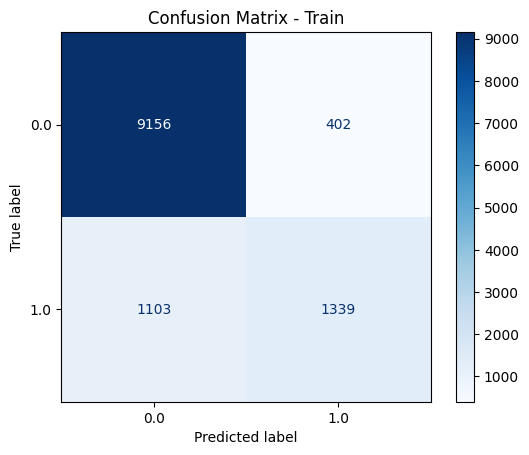

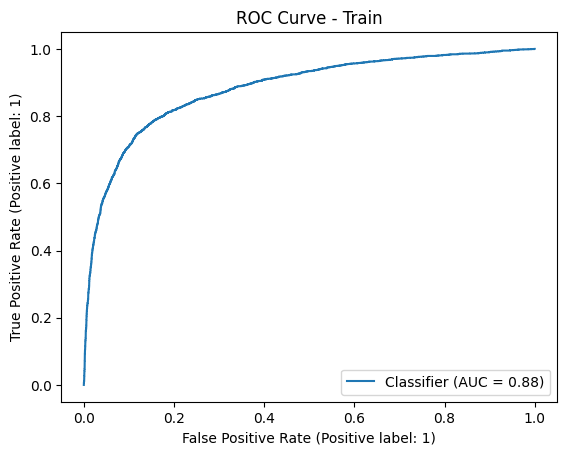


--- VALIDATION ---
ROC AUC: 0.8797
F1 Score: 0.639


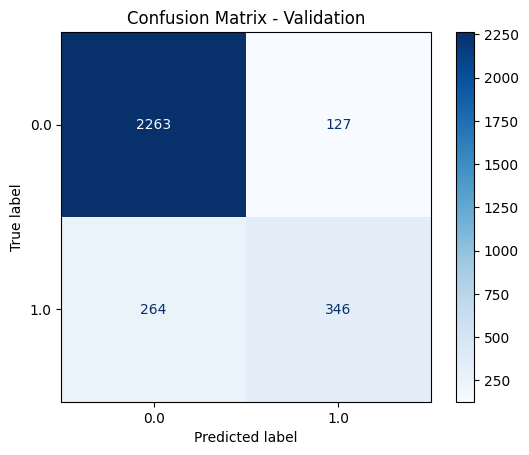

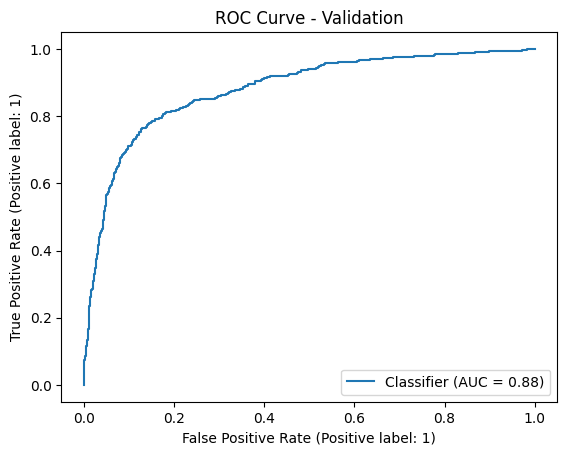

['log_reg.joblib']

In [9]:
df = pd.read_csv("train.csv")
test_raw_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

df = df.drop(columns=['id', 'CustomerId', 'Surname'])

input_cols = df.columns.drop('Exited').tolist()
target_col = 'Exited'
X = df[input_cols]
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

train_inputs = X_train.copy()
train_targets = y_train.copy()
val_inputs = X_val.copy()
val_targets = y_val.copy()

numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Pipelines
numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])
model_pipeline.fit(train_inputs, train_targets)

def evaluate_pipeline(pipeline, X, y, name):
    y_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print(f"\n--- {name.upper()} ---")
    print("ROC AUC:", round(roc_auc_score(y, y_proba), 4))
    print("F1 Score:", round(f1_score(y, y_pred), 4))

    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()
    
evaluate_pipeline(model_pipeline, train_inputs, train_targets, "Train")
evaluate_pipeline(model_pipeline, val_inputs, val_targets, "Validation")

# Save model
joblib.dump(model_pipeline, "log_reg.joblib")

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?


--- TRAIN (POLY) ---
ROC AUC: 0.9303
F1 Score: 0.7359


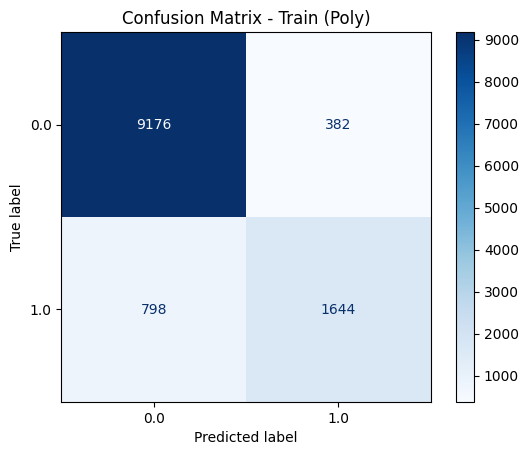

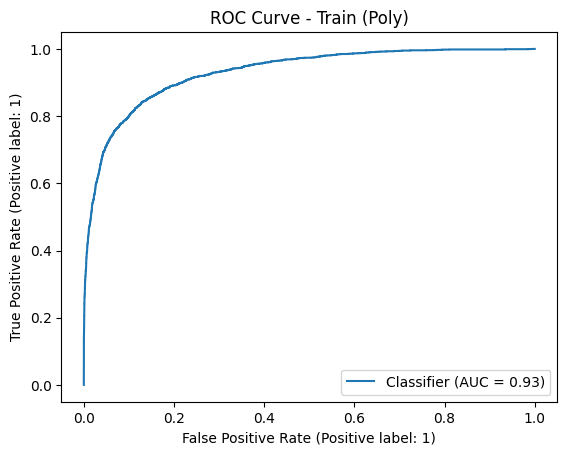


--- VALIDATION (POLY) ---
ROC AUC: 0.9275
F1 Score: 0.7223


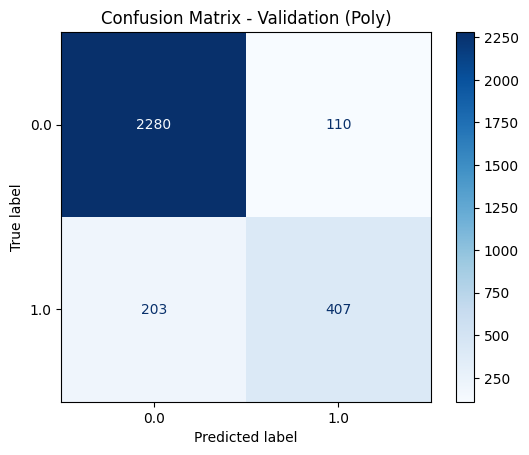

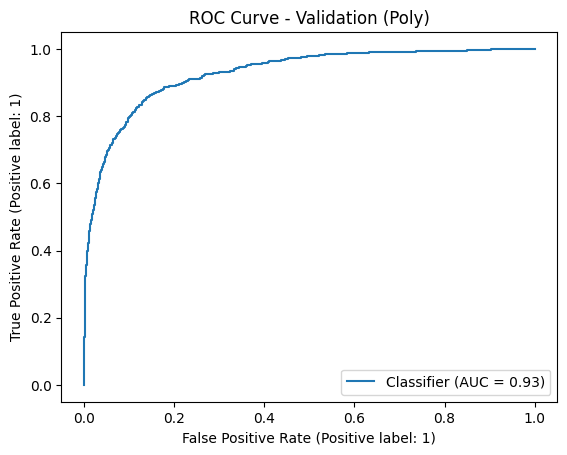

['log_reg.joblib']

In [11]:
df = pd.read_csv("train.csv")
test_raw_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

df = df.drop(columns=['id', 'CustomerId', 'Surname'])

input_cols = df.columns.drop('Exited').tolist()
target_col = 'Exited'
X = df[input_cols]
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

train_inputs = X_train.copy()
train_targets = y_train.copy()
val_inputs = X_val.copy()
val_targets = y_val.copy()

numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Pipelines
numeric_pipeline_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor_poly = ColumnTransformer([
    ("num", numeric_pipeline_poly, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

model_pipeline_poly = Pipeline([
    ('preprocessing', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])
model_pipeline_poly.fit(train_inputs, train_targets)

def evaluate_pipeline(pipeline, X, y, name):
    y_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print(f"\n--- {name.upper()} ---")
    print("ROC AUC:", round(roc_auc_score(y, y_proba), 4))
    print("F1 Score:", round(f1_score(y, y_pred), 4))

    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()
    
evaluate_pipeline(model_pipeline_poly, train_inputs, train_targets, "Train (Poly)")
evaluate_pipeline(model_pipeline_poly, val_inputs, val_targets, "Validation (Poly)")

# Save model
joblib.dump(model_pipeline_poly, "log_reg.joblib")

Метрики на train і validation досить схожі, отже перенавчання не спостерігається. Underfitting також не спостерігається, адже модель досить добре навчається і розпізнає патерни в даних. Модель добре узагальнює, оскільки показує високі метрики не лише на тренувальних, а й на валідаційних даних.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.


--- TRAIN (POLY4) ---
ROC AUC: 0.9394
F1 Score: 0.7503


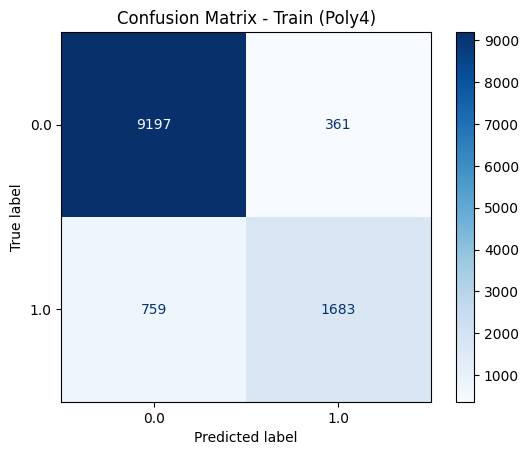

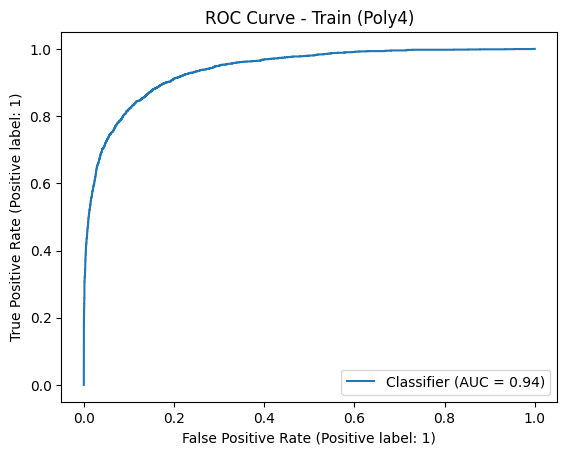


--- VALIDATION (POLY4) ---
ROC AUC: 0.9323
F1 Score: 0.7333


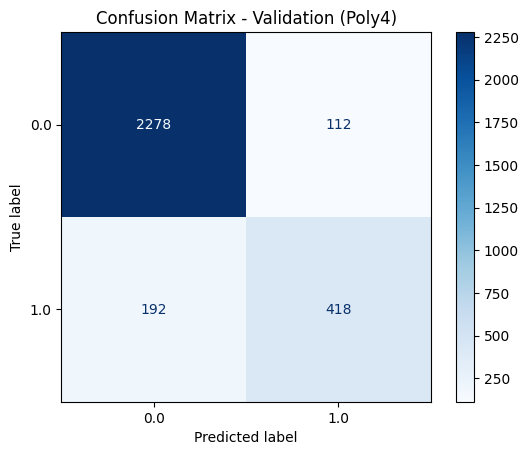

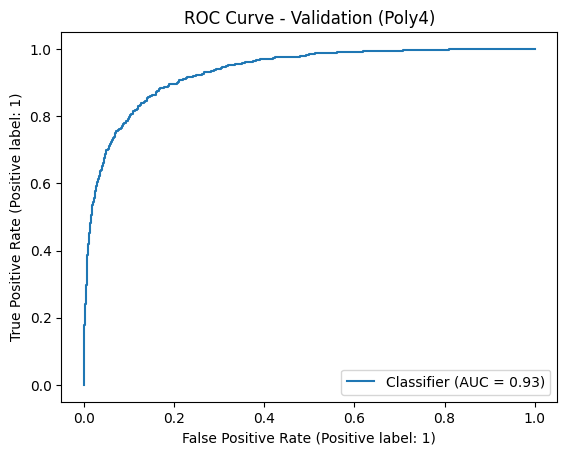

['log_reg.joblib']

In [12]:
df = pd.read_csv("train.csv")
test_raw_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

df = df.drop(columns=['id', 'CustomerId', 'Surname'])

input_cols = df.columns.drop('Exited').tolist()
target_col = 'Exited'
X = df[input_cols]
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

train_inputs = X_train.copy()
train_targets = y_train.copy()
val_inputs = X_val.copy()
val_targets = y_val.copy()

numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Pipelines
numeric_pipeline_poly4 = Pipeline([
    ("poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("scaler", StandardScaler())
])
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor_poly4 = ColumnTransformer([
    ("num", numeric_pipeline_poly4, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

model_pipeline_poly4 = Pipeline([
    ('preprocessing', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])
model_pipeline_poly4.fit(train_inputs, train_targets)

def evaluate_pipeline(pipeline, X, y, name):
    y_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print(f"\n--- {name.upper()} ---")
    print("ROC AUC:", round(roc_auc_score(y, y_proba), 4))
    print("F1 Score:", round(f1_score(y, y_pred), 4))

    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()
    
evaluate_pipeline(model_pipeline_poly4, train_inputs, train_targets, "Train (Poly4)")
evaluate_pipeline(model_pipeline_poly4, val_inputs, val_targets, "Validation (Poly4)")

# Save model
joblib.dump(model_pipeline_poly4, "log_reg.joblib")

Модель показує кращі результати, ніж з поліноміальними ознаками до 2-го степеня, адже вищі метрики AUC і F1 як на тренувальних, так і на валідаційних даних. Overfitting не спостерігається, різниця між train і validation метриками дуже невелика. Модель добре генералізує, отже, складність моделі адекватна для цієї задачі.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [14]:
df_regression = pd.read_csv("regression_data (1).csv")

In [15]:
X = df_regression.drop(columns='target')
y = df_regression['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline_poly5 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=5)),
    ('reg', LinearRegression())
])

pipeline_poly5.fit(X_train, y_train)

train_preds = pipeline_poly5.predict(X_train)
test_preds = pipeline_poly5.predict(X_test)

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

train_rmse, test_rmse, train_r2, test_r2

(3.609729759718902e-13, 35.62805277364126, 1.0, 0.45592691508365923)

Майже нульова помилка на train data, ознака сильного перенавчання. Тобто модель запам’ятала тренувальні дані і дуже погано генералізує на нові дані. Варто застосувати регуляризовані моделі, щоби зменшити складність.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [17]:
degree = 20

pipelines = {
    "Linear": Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Lasso": Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("scaler", StandardScaler()),
        ("model", Lasso(alpha=1.0, max_iter=10000))
    ]),
    "Ridge": Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    "ElasticNet": Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000))
    ])
}

results = []

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R²": train_r2,
        "Test R²": test_r2
    })

results_df = pd.DataFrame(results)
results_df

,Model,Train RMSE,Test RMSE,Train R²,Test R²
0,Linear,1.131854e-11,65.524958,1.000000,-0.840291
1,Lasso,1.479369e+00,1.392128,0.998876,0.999169
2,Ridge,1.053670e+00,27.797604,0.999430,0.668802
3,ElasticNet,1.204433e+01,20.624002,0.925524,0.817686


Найкраще генералізує Lasso, адже через сильну регуляризацію вона пригнічує зайві ознаки, що важливо при великій кількості поліноміальних ознак.